*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Systems

This chapter contains only the code, no text yet!

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/system.ipynb).

In [18]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [20]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate

In [21]:
from utils import set_precision

set_precision(3)

## Systems of Equations

If you studied algebra, you might have encountered dreaded word problems like this one:


> At a school play, 50 tickets were sold for a total of \$380. Tickets were priced as follows:
>
> - Child tickets: \$5  
> - Adult tickets: \$12  
> - Senior tickets: \$8  
>
> Each adult brought exactly two children with them, and no children attended without an adult.
>
> How many of each type of ticket were sold?

To answer questions like this, you were probably taught to define variables to represent the unknown quantities. For example, we'll define

- $c$ as the number of child tickets sold  
- $a$ as the number of adult tickets sold  
- $s$ as the number of senior tickets sold  

We can use SymPy to represent these variables with symbols.

In [22]:
c, a, s = sp.symbols('c a s')

Next we can write equations to represent the given relationships among the variable.
This equation represents the total number of tickets sold:

In [23]:
eq1 = sp.Eq(c + a + s, 50)
eq1

Eq(a + c + s, 50)

This one represents total sales.

In [24]:
eq2 = sp.Eq(5*c + 12*a + 8*s, 380)
eq2

Eq(12*a + 5*c + 8*s, 380)

And this one represents the constraint that every adult brings two children.

In [25]:
eq3 = sp.Eq(c, 2*a)
eq3

Eq(c, 2*a)

To solve these equations, we can use the SymPy function `linsolve`, which takes as parameters a list of equations and a list of unknowns. 

In [26]:
eqns = [eq1, eq2, eq3]
unknowns = [c, a, s]

sp.linsolve(eqns, unknowns)

{(20, 10, 20)}

The result is a set of solutions -- in this case there is only one: 20 children, 10 adults, and 20 seniors.

Now let's see how `linsolve` works.

## Matrix Equations

The algorithm `linsolve` uses is Gauss-Jordan elimination.
The first step is to write the system of equations as a matrix equation.
SymPy provides a function that extracts from the equations a matrix of coefficients and a vector of constants.

In [87]:
A, b = sp.linear_eq_to_matrix(eqns, unknowns)
A

Matrix([
[1,  1, 1],
[5, 12, 8],
[1, -2, 0]])

In [28]:
b

Matrix([
[ 50],
[380],
[  0]])

In this representation, the unknowns don't appear explicitly, but if we put the unknowns in a vector, `x`, we can write the equations in the form $Ax = b$.
So we can recover the original equations like this:

In [29]:
x = sp.Matrix(unknowns)
sp.Eq(A * x, b)

Eq(Matrix([
[       a + c + s],
[12*a + 5*c + 8*s],
[        -2*a + c]]), Matrix([
[ 50],
[380],
[  0]]))

Note that for a SymPy matrix, the `*` operator performs matrix multiplication.

The next step in Gauss-Jordan elimination is to form an **augmented matrix** with `b` appended to `A` as an additional column.

In [30]:
M = A.row_join(b)
M

Matrix([
[1,  1, 1,  50],
[5, 12, 8, 380],
[1, -2, 0,   0]])

Each row of the augmented matrix represents an equation with a left hand side and a right hand side.

In [41]:
row0 = M[0, :]
row0

Matrix([[1, 1, 1, 50]])

If we multiply both sides of the equation by a constant, the result is still a valid equation.

In [42]:
row0 * 5

Matrix([[5, 5, 5, 250]])

And if we add or subtract two equations, the result is a valid equation.

In [43]:
row1 = M[1, :] 
row1 - 5 * row0

Matrix([[0, 7, 3, 130]])

Notice that by subtracting rows in this way, we canceled out one of the coefficients, leaving a zero at the beginning of the row -- which means that this equation depends on one less variable.

Continuing in this way, we can use these row operations to cancel out one coefficient at a time.
We'll use the following function, which takes `M` and uses row `i` to eliminate the element in row `j`, column `k`.

In [84]:
def row_reduce(M, i, j, k):
    row_i = M[i, :]
    row_j = M[j, :]
    factor = row_j[k] / row_i[k]
    M[j, :] -= factor * row_i
    return factor

In [45]:
row_reduce(M, 0, 1, 0)
M

Matrix([
[1,  1, 1,  50],
[0,  7, 3, 130],
[1, -2, 0,   0]])

In [46]:
row_reduce(M, 0, 2, 0)
row_reduce(M, 1, 2, 1)
M

Matrix([
[1, 1,   1,   50],
[0, 7,   3,  130],
[0, 0, 2/7, 40/7]])

In [47]:
row_reduce(M, 2, 1, 2)
M

Matrix([
[1, 1,   1,   50],
[0, 7,   0,   70],
[0, 0, 2/7, 40/7]])

In [48]:
row_reduce(M, 2, 0, 2)
row_reduce(M, 1, 0, 1)
M

Matrix([
[1, 0,   0,   20],
[0, 7,   0,   70],
[0, 0, 2/7, 40/7]])

As the last step, we'll use this function to divide each row by its one remaining coefficient.

In [51]:
def normalize_rows(M):
    rows, cols = M.shape
    for i in range(rows):
        M[i, :] /= M[i, i]

In the result, the solution appears in the last column.

In [52]:
normalize_rows(M)
M

Matrix([
[1, 0, 0, 20],
[0, 1, 0, 10],
[0, 0, 1, 20]])

We can split the augmented matrix into a square matrix and a solution vector.

In [53]:
I = M[:, :-1]
sol = M[:, -1]

And we can represent the solution as a vector equality.

In [55]:
sp.Eq(I * x, sol)

Eq(Matrix([
[c],
[a],
[s]]), Matrix([
[20],
[10],
[20]]))

I called the reduced matrix `I` because that's the conventional name for the identity matrix.
If we multiply `I` by any vector, the result is the same vector.

In [56]:
I * x

Matrix([
[c],
[a],
[s]])

And if we multiply by any matrix, the result is the same matrix.

In [57]:
I * A

Matrix([
[1,  1, 1],
[5, 12, 8],
[1, -2, 0]])

Gauss-Jordan elimination is just one way to solve a matrix equation.
Let's look at another.

## Matrix Inversion

Suppose you want to solve an equation like $ax = b$, where $a$ and $b$ are scalars.
If you divide both sides by $a$, the result is $x = b/a$, which is considered a solution because we know how to do scalar division.

Unfortunately, we can't do the same thing with a matrix equation like $Ax = b$ because there's no general definition for matrix division.
But one option is to avoid division using inverse multiplication.
In the scalar equation, that means multiplying both sides by $1/a$, also denoted $a^{-1}$.

$$a^{-1} a x = a^{-1} b$$

On the left side, $a^{-1} a = 1$, so we have

$$x = a^{-1} b$$

We can do the same thing with the matrix equation.
If we can find the inverse of $A$, denoted $A^{-1}$, we can multiply both sides of the matrix equation to get:

$$A^{-1} A x = A^{-1} b$$

On the left side, the product $A^{-1} A$ is the identity matrix $I$, and we have already seen that $I x = x$, so the result is

$$x = A^{-1} b$$

which is considered a solution because we know how to do matrix multiplication.

Now all we have to do is find $A^{-1}$.
SciPy provides a function that does it.

In [58]:
from scipy.linalg import inv

A_inv = A.inv()
A_inv

Matrix([
[  8,   -1,   -2],
[  4, -1/2, -3/2],
[-11,  3/2,  7/2]])

We can confirm that $A^{-1} A = I$.

In [59]:
A_inv * A

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

And we can find a solution by evaluating the right hand side, $A^{-1} b$.

In [60]:
A_inv * b

Matrix([
[20],
[10],
[20]])

That solution should look familiar.

There are several ways to find the inverse of a matrix.
One is to write the matrix equation $A A^{-1} = I$ and use Gauss-Jordan elimination to solve for $A^{-1}$.

In [61]:
M = A.row_join(I)
M

Matrix([
[1,  1, 1, 1, 0, 0],
[5, 12, 8, 0, 1, 0],
[1, -2, 0, 0, 0, 1]])

In [62]:
def gauss_jordan_elimination(M):
    rows, cols = M.shape
    for i in range(rows):
        for j in range(rows):
            if i != j:
                row_reduce(M, i, j, i)

In [63]:
gauss_jordan_elimination(M)
M

Matrix([
[1, 0,   0,     8,   -1,    -2],
[0, 7,   0,    28, -7/2, -21/2],
[0, 0, 2/7, -22/7,  3/7,     1]])

In [64]:
normalize_rows(M)
M

Matrix([
[1, 0, 0,   8,   -1,   -2],
[0, 1, 0,   4, -1/2, -3/2],
[0, 0, 1, -11,  3/2,  7/2]])

The result is an augmented matrix that contains $I$ on the left and $A^{-1}$ on the right.

So that's one way to find the inverse of a matrix, but the `inv` uses a different algorithm, called LU decomposition.

## LU Decomposition

I will start by explaining what LU decomposition is, then why it is useful, and then how we compute it.

In general, a **decomposition** of a matrix, $A$, is a set of matrices whose product is $A$.
More specifically, an LU decomposition is two matrixes, $L$ and $U$, where $L U = A$.
Also, $L$ is a lower triangular matrix and $U$ is an upper triangular matrix -- and I'll explain what that means below.

SciPy matrices have a method that finds an LU decomposition.

In [65]:
L, U, perm = A.LUdecomposition()

We can confirm that $L U = A$.

In [69]:
sp.Eq(L * U, A)

True

`L` is lower triangular, which means all of the non-zero elements are on or below the main diagonal.

In [67]:
L

Matrix([
[1,    0, 0],
[5,    1, 0],
[1, -3/7, 1]])

And `U` is upper triangular, which means all of the non-zero elements are on or above the main diagonal.

In [68]:
U

Matrix([
[1, 1,   1],
[0, 7,   3],
[0, 0, 2/7]])

`LUdecomposition` sometimes permutes (swaps) the rows of the matrix, so it returns a third value, `perm`, which is a list of pairs, where each pair contains the indices of two rows that were swapped.

In this example, `perm` is an empty list, meaning that there were no swaps.
So we'll ignore this detail for now.

In [72]:
perm

[]

LU decomposition is useful because it provides an efficient way to solve a matrix equation -- and it is numerically stable, which means that it can compute the solution more precisely than multiplication by a matrix inverse.

If we have $L$ and $U$ such that $L U = A$, and we want to solve $A x = b$, we can do it by rewriting the matrix equation as $L U x = b$, and substituting in $y$ for $U x$.
Then we

* Solve $L y = b$ for $y$, and

* Solve $U x = y$ for $x$.

Here's the first step:

In [31]:
y = L.solve(b)
y

Matrix([
[  50],
[ 130],
[40/7]])

And here's the second:

In [32]:
x = U.solve(y)
x

Matrix([
[20],
[10],
[20]])

That result should look familiar.
This process is efficient because the `solve` methods provided by `L` and `U` provide take advantage of their structure, so the number of row operations is minimized.

In [79]:
M = A.row_join(I)
M

Matrix([
[1,  1, 1, 1, 0, 0],
[5, 12, 8, 0, 1, 0],
[1, -2, 0, 0, 0, 1]])

Similar to Gauss-Jordan except

* Fewer operations

* It stores the factors computed by row_reduce

In [91]:
def LUdecomposition(A):
    rows, cols = A.shape
    U = A.copy()
    L = sp.eye(rows)
    
    for i in range(rows):
        for j in range(rows):
            if i < j:
                L[j, i] = row_reduce(U, i, j, i)

    return L, U

In [92]:
L, U = LUdecomposition(A)
L

Matrix([
[1,    0, 0],
[5,    1, 0],
[1, -3/7, 1]])

In [93]:
U

Matrix([
[1, 1,   1],
[0, 7,   3],
[0, 0, 2/7]])

In [83]:
L

Matrix([
[1,    0, 0],
[5,    1, 0],
[1, -3/7, 1]])

Those results should look familiar -- and we can check to make sure.

In [95]:
sp.Eq(L * U, A)

True

In [70]:
y = sp.Matrix(sp.symbols('y0, y1, y2'))

lhs = L * y
rhs = b

sp.Eq(lhs, rhs)

Eq(Matrix([
[              y0],
[       5*y0 + y1],
[y0 - 3*y1/7 + y2]]), Matrix([
[ 50],
[380],
[  0]]))

In [23]:
eq0 = sp.Eq(lhs[0], rhs[0])
eq0

Eq(y0, 50)

In [24]:
eq1 = sp.Eq(lhs[1], rhs[1])
eq1

Eq(5*y0 + y1, 380)

In [25]:
eq1 = eq1.subs(eq0.lhs, eq0.rhs)
eq1

Eq(y1 + 250, 380)

In [26]:
eq1 = sp.Eq(eq1.lhs - 250, eq1.rhs - 250)
eq1

Eq(y1, 130)

In [27]:
eq2 = sp.Eq(lhs[2], rhs[2])
eq2

Eq(y0 - 3*y1/7 + y2, 0)

In [28]:
eq2 = eq2.subs([(eq0.lhs, eq0.rhs), (eq1.lhs, eq1.rhs)])
eq2

Eq(y2 - 40/7, 0)

In [29]:
term = sp.Rational(40, 7)
eq2 = sp.Eq(eq2.lhs + term, eq2.rhs + term)
eq2

Eq(y2, 40/7)

In [30]:
y = [eq.rhs for eq in [eq0, eq1, eq2]]
y

[50, 130, 40/7]

In [34]:
A * x - b

Matrix([
[0],
[0],
[0]])

In [35]:
b

Matrix([
[ 50],
[380],
[  0]])

LU decomposition is particularly useful if we would like to solve the same system of equations with different values of the right hand side, $b$.
For example, suppose the person collecting payment makes an error, and at the end of the evening, the total in the till is only \$379, just a dollar short.

In this scenario, the right hand side is:

In [36]:
b2 = sp.Matrix([50, 379, 0])

And since we have already computed $L$ and $U$, we can use them to solve the system with this new right hand side.

In [37]:
y2 = L.solve(b2)
x2 = U.solve(y2)
x2

Matrix([
[  21],
[21/2],
[37/2]])

Since the elements of the solution are not all integers, we can tell that something went wrong.


## Numerical solution

In [38]:
A_np = np.array(A).astype(float)
b_np = np.array(b).astype(float).flatten()

In [39]:
from scipy.linalg import solve

np.linalg.solve(A_np, b_np)

array([20., 10., 20.])

In [40]:
from scipy.linalg import lu

P, L, U = lu(A_np)

In [41]:
L

array([[1.        , 0.        , 0.        ],
       [0.2       , 1.        , 0.        ],
       [0.2       , 0.31818182, 1.        ]])

In [42]:
U

array([[ 5.        , 12.        ,  8.        ],
       [ 0.        , -4.4       , -1.6       ],
       [ 0.        ,  0.        , -0.09090909]])

In [43]:
P

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [44]:
Pb = P.T @ b_np

In [45]:
y = np.linalg.solve(L, Pb)
y

array([380.        , -76.        ,  -1.81818182])

In [46]:
x_np = np.linalg.solve(U, y)
x_np

array([20., 10., 20.])

In [47]:
from scipy.linalg import lu_factor, lu_solve

LU, piv = lu_factor(A_np)
LU

array([[ 5.        , 12.        ,  8.        ],
       [ 0.2       , -4.4       , -1.6       ],
       [ 0.2       ,  0.31818182, -0.09090909]])

In [48]:
piv

array([1, 2, 2], dtype=int32)

In [49]:
x_lu = lu_solve((LU, piv), b_np)
x_lu

array([20., 10., 20.])

## Circuit Analysis

In [50]:
def make_graph():
    G = nx.DiGraph()
    G.graph['constants'] = []
    G.graph['unknowns'] = []
    return G

In [51]:
def make_constant(G, name, **kwargs):
    symbol = sp.Symbol(name)
    G.graph['constants'].append(symbol)
    return symbol

In [52]:
def make_unknown(G, name, **kwargs):
    symbol = sp.Symbol(name)
    G.graph['unknowns'].append(symbol)
    return symbol

In [53]:
def make_voltage_divider():
    G = make_graph()
    G.graph['fixed'] = ['in', 'gnd']
    
    G.add_edge('in', 'out', component='R', name='R1')
    G.add_edge('out', 'gnd', component='R', name='R2')

    add_symbols(G)
    return G

In [54]:
def add_symbols(G):
    # add currents to edges
    for u, v, data in G.edges(data=True):
        name = data['name']
        data['resistance'] = make_constant(G, name)
        data['current'] = make_unknown(G, f"I_{name}")

    # Assign voltages to nodes
    for node, data in G.nodes(data=True):
        if node in G.graph['fixed']:
            data['voltage'] = make_constant(G, f"V_{node}")
        else:
            data['voltage'] = make_unknown(G, f"V_{node}")

In [55]:
G = make_voltage_divider()

In [56]:
def draw_graph(G):
    G.graph['graph'] = {'rankdir': 'LR'}
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos)

    edge_labels = {(u, v): str(d['resistance']) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')
    plt.tight_layout()

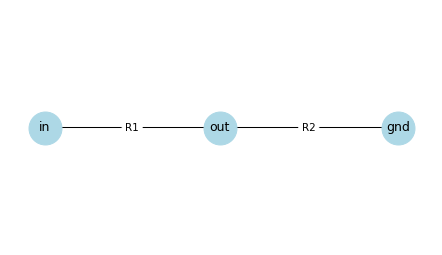

In [57]:
draw_graph(G)

In [58]:
def make_ohm_equations(G):
    ohm_eqs = []
    
    for u, v, data in G.edges(data=True):
        if data['component'] == 'R':
            V_from = G.nodes[u]['voltage']
            V_to = G.nodes[v]['voltage']
            R = data['resistance']
            I = data['current']
            
            eq = sp.Eq(V_from - V_to, I * R)
            ohm_eqs.append(eq)
            
    return ohm_eqs

In [59]:
def make_kcl_equations(G):
    kcl_eqs = []
    
    for node in G.nodes:
        if node in G.graph['fixed']:
            continue

        expr_out = sum(data['current'] for _, _, data in G.out_edges(node, data=True))
        expr_in = sum(data['current'] for _, _, data in G.in_edges(node, data=True))
        eq = sp.Eq(expr_in, expr_out)
        
        kcl_eqs.append(eq)
        
    return kcl_eqs

In [60]:
from IPython.display import display

def display_equations(eqs):
    for eqn in ohm_eqs:
        display(eqn)

In [61]:
ohm_eqs = make_ohm_equations(G)

In [62]:
display_equations(ohm_eqs)

Eq(V_in - V_out, I_R1*R1)

Eq(-V_gnd + V_out, I_R2*R2)

In [63]:
kcl_eqs = make_kcl_equations(G)

display_equations(kcl_eqs)

Eq(V_in - V_out, I_R1*R1)

Eq(-V_gnd + V_out, I_R2*R2)

In [64]:
eqs = ohm_eqs + kcl_eqs

In [65]:
A, b = sp.linear_eq_to_matrix(eqs, G.graph['unknowns'])
A

Matrix([
[-R1,   0, -1],
[  0, -R2,  1],
[  1,  -1,  0]])

In [66]:
b

Matrix([
[-V_in],
[V_gnd],
[    0]])

In [67]:
solution_vector = A.LUsolve(b)
solution_vector.simplify()

In [68]:
sp.Eq(sp.Matrix(G.graph['unknowns']), solution_vector)

Eq(Matrix([
[ I_R1],
[ I_R2],
[V_out]]), Matrix([
[     (-V_gnd + V_in)/(R1 + R2)],
[     (-V_gnd + V_in)/(R1 + R2)],
[(R1*V_gnd + R2*V_in)/(R1 + R2)]]))

In [69]:
subs = dict(zip(G.graph['constants'], [1000, 4000, 5, 0]))
subs

{R1: 1000, R2: 4000, V_in: 5, V_gnd: 0}

In [70]:
evaluated = solution_vector.subs(subs)
evaluated

Matrix([
[1/1000],
[1/1000],
[     4]])

## R2R Ladder

In [71]:
def make_r2r_ladder(N):
    G = make_graph()
    G.graph['fixed'] = [f'D{i}' for i in range(N)] + ['gnd']  

    start = 'gnd'
    for i in range(N):
        node = f'n{i}'
        pin = f'D{i}'
        G.add_edge(start, node, component='R', name=f'r{i}')
        G.add_edge(pin, node, component='R', name=f'R{i}')
        start = node
    
    G['gnd']['n0']['name'] = 'R'
    add_symbols(G)
    return G

In [72]:
N = 3
G = make_r2r_ladder(N)

In [73]:
G.graph['constants']

[R, r1, R0, r2, R1, R2, V_gnd, V_D0, V_D1, V_D2]

In [74]:
G.graph['unknowns']

[I_R, I_r1, I_R0, I_r2, I_R1, I_R2, V_n0, V_n1, V_n2]

In [75]:
G.graph['fixed']

['D0', 'D1', 'D2', 'gnd']

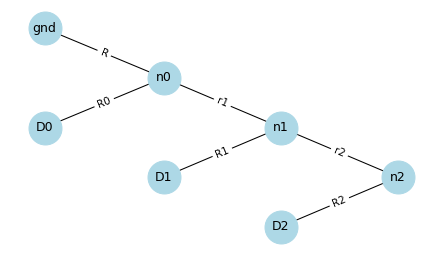

In [76]:
from system import draw_graph

draw_graph(G)

In [77]:
ohm_eqs = make_ohm_equations(G)
kcl_eqs = make_kcl_equations(G)

for eqn in ohm_eqs:
    display(eqn)

for eqn in kcl_eqs:
    display(eqn)

Eq(V_gnd - V_n0, I_R*R)

Eq(V_n0 - V_n1, I_r1*r1)

Eq(V_D0 - V_n0, I_R0*R0)

Eq(V_n1 - V_n2, I_r2*r2)

Eq(V_D1 - V_n1, I_R1*R1)

Eq(V_D2 - V_n2, I_R2*R2)

Eq(I_R + I_R0, I_r1)

Eq(I_R1 + I_r1, I_r2)

Eq(I_R2 + I_r2, 0)

In [78]:
unknowns = G.graph['unknowns']
unknowns

[I_R, I_r1, I_R0, I_r2, I_R1, I_R2, V_n0, V_n1, V_n2]

In [79]:
eqs = ohm_eqs + kcl_eqs
A, b = sp.linear_eq_to_matrix(eqs, unknowns)
A

Matrix([
[-R,   0,   0,   0,   0,   0, -1,  0,  0],
[ 0, -r1,   0,   0,   0,   0,  1, -1,  0],
[ 0,   0, -R0,   0,   0,   0, -1,  0,  0],
[ 0,   0,   0, -r2,   0,   0,  0,  1, -1],
[ 0,   0,   0,   0, -R1,   0,  0, -1,  0],
[ 0,   0,   0,   0,   0, -R2,  0,  0, -1],
[ 1,  -1,   1,   0,   0,   0,  0,  0,  0],
[ 0,   1,   0,  -1,   1,   0,  0,  0,  0],
[ 0,   0,   0,   1,   0,   1,  0,  0,  0]])

In [80]:
b

Matrix([
[-V_gnd],
[     0],
[ -V_D0],
[     0],
[ -V_D1],
[ -V_D2],
[     0],
[     0],
[     0]])

In [81]:
solution_vector = A.LUsolve(b)

In [82]:
solution_vector[-1].simplify()

(R*R0*R1*V_D2 + R*R0*R2*V_D1 + R*R1*R2*V_D0 + R0*R1*R2*V_gnd + V_D2*r2*(R*R0 + (R + R0)*(R1 + r1)) + r1*(R + R0)*(R1*V_D2 + R2*V_D1))/(R*R0*R1 + R1*r1*(R + R0) + (R2 + r2)*(R*R0 + (R + R0)*(R1 + r1)))

In [83]:
constants = G.graph['constants']
constants

[R, r1, R0, r2, R1, R2, V_gnd, V_D0, V_D1, V_D2]

In [84]:
def set_values(constants, **values):
    subs = {}
    for symbol in constants:
        for key, value in values.items():
            if symbol.name.startswith(key):
                subs[symbol] = value
    
    return subs

In [85]:
subs = set_values(constants, r=10000, R=20000, V_gnd=0, V_D=4)
subs

{R: 20000,
 r1: 10000,
 R0: 20000,
 r2: 10000,
 R1: 20000,
 R2: 20000,
 V_gnd: 0,
 V_D0: 4,
 V_D1: 4,
 V_D2: 4}

In [86]:
evaluated = solution_vector[-1].subs(subs)
evaluated.evalf()

3.50000000000000

In [87]:
4 * (2**N-1) / 2**N

3.5

### Exercise

Substitute values into A and b, convert them to NumPy arrays, and use the NumPy solver to solve the system numerically.

### Exercise

How big a difference is this really?

In [88]:
from time import perf_counter

n = 100
A = np.random.rand(n, n)
b = np.random.rand(n)

x1 = solve(A, b)

In [89]:
t0 = perf_counter()
x1 = solve(A, b)
t1 = perf_counter()
print(f"Solve time:    {t1 - t0:.4f} sec")

Solve time:    0.0006 sec


In [90]:
t2 = perf_counter()
A_inv = inv(A)
x2 = A_inv @ b
t3 = perf_counter()

print(f"Inverse time:  {t3 - t2:.4f} sec")

Inverse time:  0.0043 sec


## Strain Gauge

In [113]:
def make_quarter_bridge():
    G = make_graph()
    G.graph['fixed'] = ['plus', 'minus']
    
    # One active strain gauge and three fixed resistors
    G.add_edge('plus', 'A', component='R', name='R1')         # Strain gauge
    G.add_edge('minus', 'B', component='R', name='R2')
    G.add_edge('A', 'out', component='R', name='R3')
    G.add_edge('B', 'out', component='R', name='R4')

    add_symbols(G)
    return G

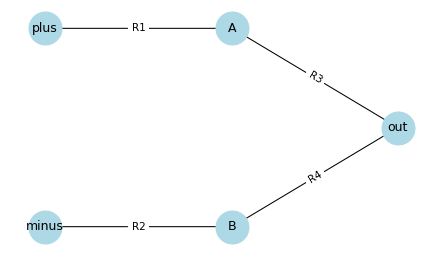

In [114]:
G = make_quarter_bridge()
draw_graph(G)

In [116]:
ohm_eqs = make_ohm_equations(G)
kcl_eqs = make_kcl_equations(G)

eqs = ohm_eqs + kcl_eqs
unknowns = G.graph['unknowns']
constants = G.graph['constants']

A, b = sp.linear_eq_to_matrix(eqs, unknowns)
solution_vector = A.LUsolve(b)
solution_vector[-1].simplify()

(R1*V_minus + R2*V_plus + R3*V_minus + R4*V_plus)/(R1 + R2 + R3 + R4)

In [119]:
subs = set_values(constants, R2=1000, R3=1000, R4=1000, V_plus=5, V_minus=0)
evaluated = solution_vector[-1].subs(subs)
evaluated.simplify()

10000/(R1 + 3000)

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)